In [1]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
from datasets.seq_mnist import SequentialMNIST_double
from datasets import seq_mnist as sm

import models.seqae as seqae
import models.base_networks as bn 
import models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import notebook_utils as nb
from utils import evaluations as ev



import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
jobdir = '/mnt/vol21/masomatics/ULASclone/jobs'

mode = 'so3'
dat_root = f"""/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/{mode}"""

playground_path = os.path.join(result_dir, '20220913_playground_model')


print(os.path.exists(playground_path))

print(nb.filter_list('double', os.listdir(result_dir)))
targpath = os.path.join(result_dir, '20221116_mnist_double_0')
print(os.path.exists(targpath))

True
['20221031_double_mnist_two_0', '20221104_mnist_double_0', '20221103_mnist_double_0', '20221116_mnist_double_0', '20221101_mnist_double_0', '20221031_double_mnist_0', '20221101_mnist_double_two_0']
True


In [292]:
reload(nb)
targlist = os.listdir(targpath)

targlist = nb.model_exists(targlist,  targpath)

targlist = nb.filter_queries(query_list=['pair_transitionTrue', 'dim_a8' , 'dim_m256'] , mylist=targlist)

print(targlist)



['pair_transitionTrue_dim_m256_dim_a8']


In [293]:
reload(ev)
reload(sm)
results = {} 
inferred_Ms = {} 
model_configs = {}
models = {}
tp = 30
n_cond = 2
device =0
predictive = False
reconstructive = False
repeats=3


targdir_pathlist = [os.path.join(targpath, targdir) for targdir in targlist] 

#targdir_pathlist = ['/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221116_mnist_double_0/pair_transitionFalse_dim_m256_dim_a8']
#targdir_pathlist = []
#targdir_pathlist.append(playground_path)

print(targdir_pathlist)

reload(ev)
reload(bn)
allresults, targ, xnext = ev.prediction_evaluation(targdir_pathlist, device=0,
                                                                        n_cond=2,
                                                                        tp=tp,
                                                                    repeats=1,
                           predictive= False , reconstructive = False)

results = allresults['results']




['/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221116_mnist_double_0/pair_transitionTrue_dim_m256_dim_a8']
{'args': {'T': 32, 'backgrnd': False, 'max_T': 32, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'pair_transition': True, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'same_object': True, 'train': True}, 'fn': './datasets/seq_mnist.py', 'name': 'SequentialMNIST_double'}
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221116_mnist_double_0/pair_transitionTrue_dim_m256_dim_a8 
 snapshot_model_iter_50000


100%|██████████| 183/183 [00:40<00:00,  4.56it/s]

tensor([0.0286, 0.0409, 0.0590, 0.0796, 0.1047, 0.1359, 0.1739, 0.2158, 0.2662,
        0.3162, 0.3785, 0.4369, 0.5048, 0.5797, 0.6547, 0.7407, 0.8241, 0.9163,
        1.0201, 1.1104, 1.2258, 1.3393, 1.4445, 1.5579, 1.6888, 1.8183, 1.9316,
        2.0665, 2.2061, 2.3471])


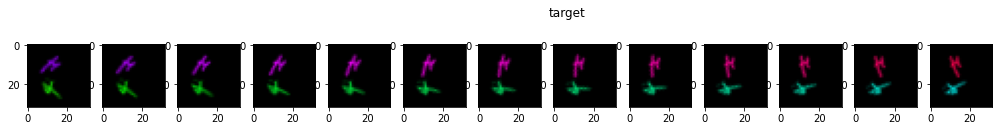

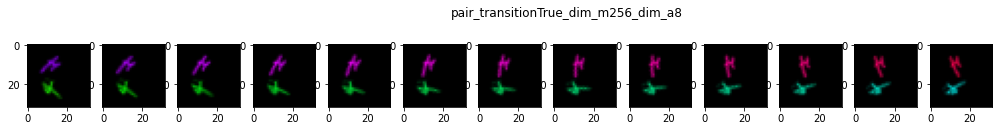

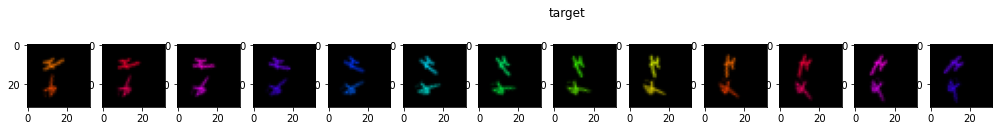

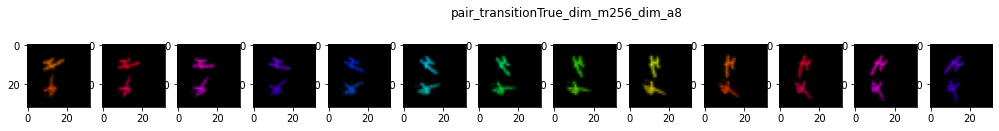

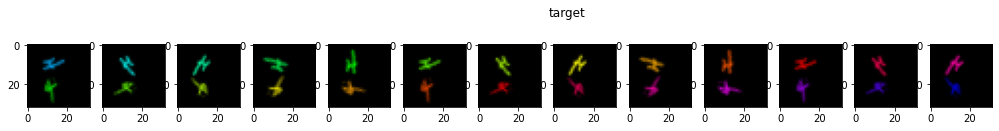

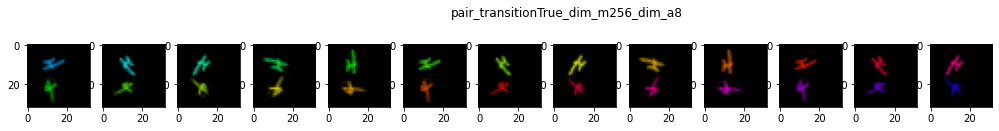

In [295]:
#mode = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221104_mnist_double_0/same_objectFalse_dim_m128'
#mode = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221116_mnist_double_0/pair_transitionTrue_dim_m128_dim_a16'
mode = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221116_mnist_double_0/pair_transitionTrue_dim_m256_dim_a8'


tp =15
device = 0
reload(sm)
for idx in list(range(0, 3)):
    figsize = (20,2)


    plt.figure(figsize = figsize)
    for k in range(tp-n_cond):
        tn = torch.permute(targ[idx][k+n_cond], (1,2,0))
        plt.subplot(1, tp, k+1)
        plt.imshow(tn, interpolation=None)
    plt.suptitle("target")  

#     for mode in list(allresults['models'].keys()):
    plt.figure(figsize = figsize)
    xnext, M = ev.predict(targ, allresults['models'][mode].to(device),
                n_cond=2, tp=tp, device=device, swap =False,
                predictive=False, reconstructive=False)
    xnext = xnext.to('cpu')
    M = M.to('cpu')
    for k in range(tp-n_cond):
        xn = torch.permute(xnext[idx][k], (1,2,0))
        plt.subplot(1, tp, k+1)
        plt.imshow(xn, interpolation=None)
    plt.suptitle(mode.split('/')[-1])    



/tmp/ipykernel_924/2686223656.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(datseq[k]).permute([1, 2, 0]))
/tmp/ipykernel_924/2686223656.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(datseq_two[k]).permute([1, 2, 0]))


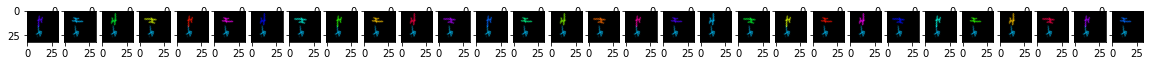

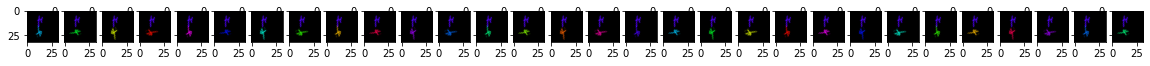

In [296]:
reload(sm)
checkmodelpath = mode
config = nb.load_config(checkmodelpath)
data_args = config['train_data']['args']
#data_args['T'] = tp - n_cond
data_args['T'] = 30

check_idx = 13
seedval = 1

double_dat = sm.SequentialMNIST_double(**data_args)
plt.figure(figsize=(20, 20))
np.random.seed(seedval)
datseq = double_dat.one_obj_immobile(check_idx)
np.random.seed(seedval)
datseq_two = double_dat.one_obj_immobile(check_idx, mode=0)

datseq = [torch.tensor(datseq[k]) for k in range(len(datseq))]
for k in range(len(datseq)):
    plt.subplot(5, len(datseq),  k+1)
    plt.imshow(torch.tensor(datseq[k]).permute([1, 2, 0])) 
    
plt.figure(figsize=(20, 20))
datseq_two = [torch.tensor(datseq_two[k]) for k in range(len(datseq_two))]
for k in range(len(datseq_two)):
    plt.subplot(5, len(datseq_two),  k+1)
    plt.imshow(torch.tensor(datseq_two[k]).permute([1, 2, 0])) 

In [297]:
checkmodel = allresults['models'][checkmodelpath].to('cpu')
encoded = checkmodel.encode(torch.stack(datseq).unsqueeze(0))[0].detach()
encoded_two = checkmodel.encode(torch.stack(datseq_two).unsqueeze(0))[0].detach()

In [298]:
from utils import optimize_bd_cob as obc 
reload(obc)
Ms = allresults['Ms'][checkmodelpath]
normalize=False
ChangeB= obc.optimize_bd_cob(Ms,  lr=0.05, epochs_monitor=10, n_epochs=200, normalize=True) 

ep:9 loss:3.2972204512988244
ep:19 loss:3.288589165170729
ep:29 loss:3.2863585807737605
ep:39 loss:3.283625244318888
ep:49 loss:3.2829107023681203
ep:59 loss:3.2806961701284405
ep:69 loss:3.2801920297577625
ep:79 loss:3.2794975626350307
ep:89 loss:3.2778790836177514
ep:99 loss:3.2787441270313047
ep:109 loss:3.2771694744257682
ep:119 loss:3.2757035124510048
ep:129 loss:3.2762091358978838
ep:139 loss:3.2753155215967604
ep:149 loss:3.2760098489005856
ep:159 loss:3.275917294579636
ep:169 loss:3.2750682005609644
ep:179 loss:3.2744511685441595
ep:189 loss:3.274595943471823
ep:199 loss:3.274722806397712


In [299]:
PMPs = ChangeB(Ms)


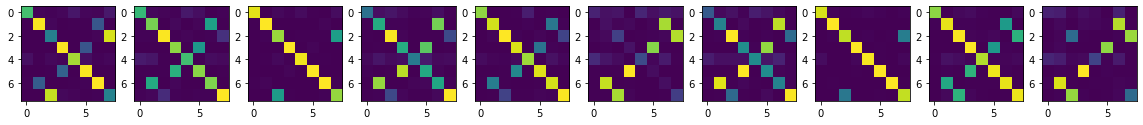

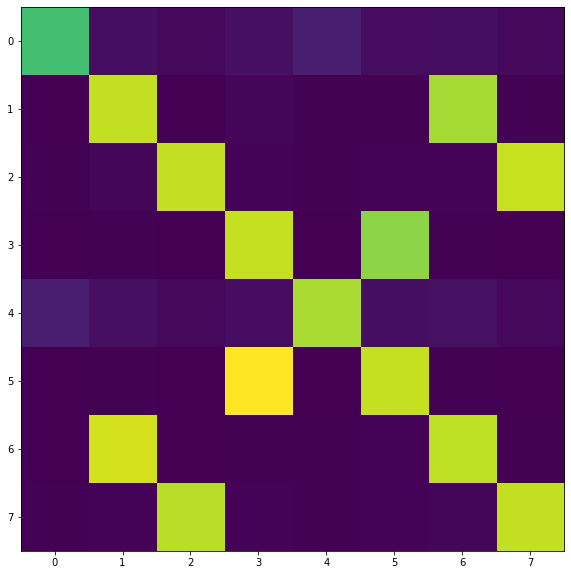

In [300]:
plt.figure(figsize=(20, 20))
for k in range(10):
    plt.subplot(1, 10, k+1)
    plt.imshow(torch.abs(PMPs[k]).detach().to('cpu'))
    
plt.figure(figsize=(10, 10))
plt.imshow(torch.mean(torch.abs(PMPs.detach()), axis=0))



In [301]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee



In [302]:
reload(obc)
selections = obc.obtain_blocks(torch.mean(torch.abs(PMPs.detach()), axis=0))
print(selections)
selection = selections[3]
print(selection)




7 1 1
5 2 3
3 2 5
1 2 7
0 1 8
[[0], [1, 6], [2, 7], [3, 5], [4]]
[3, 5]


/tmp/ipykernel_924/1398056009.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, np.ceil(len(selections)/2), k)


torch.Size([30, 256, 2])
torch.Size([30, 256, 2])
torch.Size([30, 256, 2])


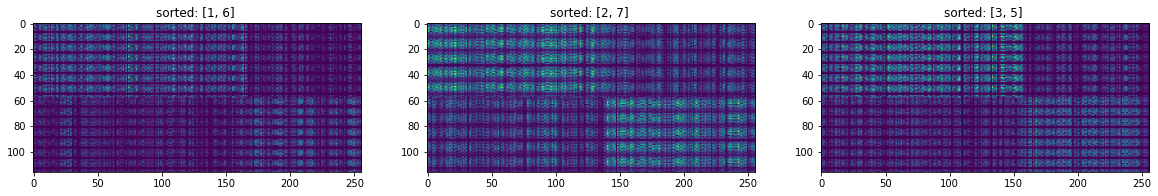

In [303]:
from utils import optimize_lasso as ol 
import einops


onewins = []
twowins = [] 
reload(ol)

plt.figure(figsize=(20,10))

k=0
for selection in selections:
    if len(selection)> 1: 
        k = k+1
        plt.subplot(2, np.ceil(len(selections)/2), k)
        encodedU = (encoded.to('cpu') @ ChangeB.U).detach()[:, :, selection] 
        encoded_twoU = (encoded_two.to('cpu') @ ChangeB.U).detach()[:, :, selection] 
        print(encodedU.shape)

        #plt.figure(figsize=(20,10))
        deltaU = encodedU[1:] - encodedU[0]
        deltaU = einops.rearrange(deltaU, 't s a -> (t a) s')
        delta_twoU = encoded_twoU[1:] - encoded_twoU[0]
        delta_twoU = einops.rearrange(delta_twoU, 't s a -> (t a) s')

        #plt.imshow(torch.abs(deltaU.detach().to('cpu')))

#         plt.imshow(torch.cat([torch.abs(deltaU.detach().to('cpu')),  torch.abs(delta_twoU.detach().to('cpu'))]  ))
#         plt.title(f"""raw : {selection} """)



        deltaUsort, delta_twoUsort, (onewin, twowin) = ol.sort_pair_col(deltaU, delta_twoU)
    
    
    
        onewins.append(onewin)
        twowins.append(twowin)

        plt.imshow(torch.cat([torch.abs(deltaUsort.detach().to('cpu')),  torch.abs(delta_twoUsort.detach().to('cpu'))]  ))
        plt.title(f"""sorted: {selection} """)




#plt.imshow(torch.cat([normalize_row(torch.abs(deltaU.detach().to('cpu'))),  normalize_row(torch.abs(delta_twoU.detach().to('cpu')))]  ))

In [304]:
data_args

{'T': 30,
 'backgrnd': False,
 'max_T': 9,
 'max_angle_velocity_ratio': [-0.5, 0.5],
 'max_color_velocity_ratio': [-0.5, 0.5],
 'only_use_digit4': True,
 'pair_transition': True,
 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST',
 'same_object': True,
 'train': True}

In [305]:
encodedU[0].shape

torch.Size([256, 2])

In [306]:
# Covariance Attempt:
encodedU.shape

torch.Size([30, 256, 2])

In [307]:
reload(ol)

<module 'utils.optimize_lasso' from '../utils/optimize_lasso.py'>

In [308]:
aaa =  torch.einsum('t s a, t r a -> t s r', encodedU, encodedU)

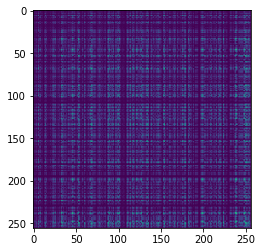

In [309]:

covmat = torch.abs(ol.covariance(encodedU))
plt.imshow(covmat)

# Analysis with Covariance Block Diagonalization

In [320]:
reload(ol)
#changeb = ol.optimize_cov_blocks(encodedU)
encoded_Ucomb = torch.cat([encodedU, encoded_twoU])
changeb = ol.optimize_cov_blocks(encoded_Ucomb, lr=0.0005)



ep:499 loss:252.02926635742188
ep:999 loss:252.02197265625
ep:1499 loss:251.89254760742188
ep:1999 loss:250.7447509765625


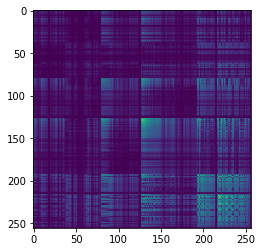

In [321]:
reload(obc)
plt.imshow(obc.blockify(covmat))

In [322]:
encodedUP = changeb(encodedU).detach()
encoded_twoUP = changeb(encoded_twoU).detach()

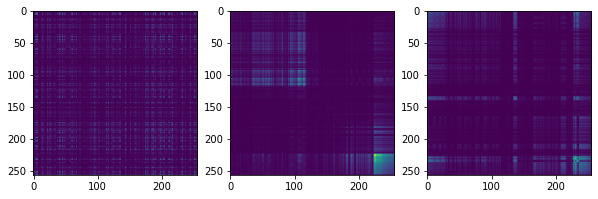

In [323]:
reload(obc)
covmatP = torch.abs(ol.covariance(encodedUP))
covmat_twoP = torch.abs(ol.covariance(encoded_twoUP))

plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(covmatP)
plt.subplot(1, 3, 2)
plt.imshow(obc.blockify(covmatP))

plt.subplot(1, 3, 3)
plt.imshow(obc.blockify(covmat_twoP))
# selection_covmat = obc.obtain_blocks_old(covmatP)

# covmat_sorted = [] 
# for k in range(len(selection_covmat)):
#     covmat_sorted = covmat_sorted + selection_covmat[k] 

    

/tmp/ipykernel_924/43657161.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, np.ceil(len(selections)/2), k)


ep:499 loss:250.20925903320312
ep:999 loss:249.1363983154297
ep:1499 loss:248.6992645263672
ep:1999 loss:248.2020263671875
ep:2499 loss:247.5570831298828
ep:2999 loss:246.76760864257812
ep:499 loss:249.1036834716797
ep:999 loss:246.44085693359375
ep:1499 loss:244.47067260742188
ep:1999 loss:243.26034545898438
ep:2499 loss:242.0518341064453
ep:2999 loss:241.1491241455078
ep:499 loss:251.75796508789062
ep:999 loss:251.16160583496094
ep:1499 loss:248.6783905029297
ep:1999 loss:246.82373046875
ep:2499 loss:246.3468017578125
ep:2999 loss:246.04083251953125
ep:499 loss:252.045654296875
ep:999 loss:252.01864624023438
ep:1499 loss:252.0162811279297
ep:1999 loss:252.01226806640625
ep:2499 loss:251.85125732421875
ep:2999 loss:250.72052001953125
ep:499 loss:251.7964630126953
ep:999 loss:251.54000854492188
ep:1499 loss:251.06082153320312
ep:1999 loss:250.2406463623047
ep:2499 loss:248.01220703125
ep:2999 loss:247.2016143798828


RuntimeError: svd_cpu: the updating process of SBDSDC did not converge (error: 1)

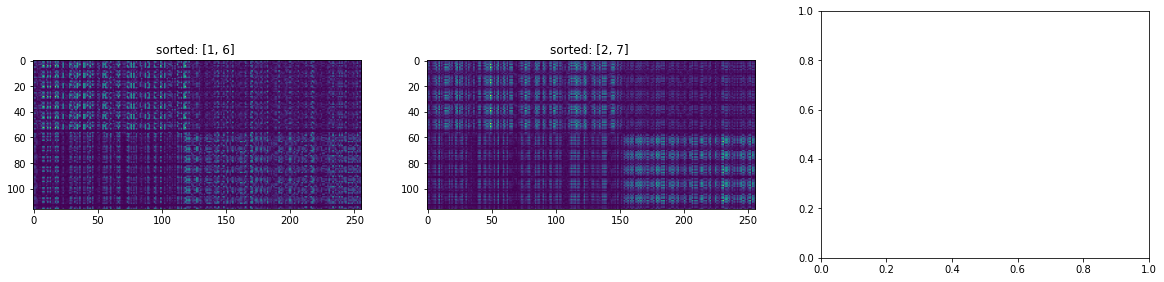

In [349]:



onewins = []
twowins = [] 
reload(ol)

changeUstat = [] 
plt.figure(figsize=(20,10))
k=0
for selection in selections:
    if len(selection)> 1: 
        k = k+1
        plt.subplot(2, np.ceil(len(selections)/2), k)
        #prepare 
        encodedU = (encoded.to('cpu') @ ChangeB.U).detach()[:, :, selection] 
        encoded_twoU = (encoded_two.to('cpu') @ ChangeB.U).detach()[:, :, selection] 
        
        encoded_Ucomb = torch.cat([encodedU, encoded_twoU])
        
        #for 8
        changeb = ol.optimize_cov_blocks(encoded_Ucomb, normalize=True, lr=0.0001, n_epochs=3000)


        
        
        #changeb = ol.optimize_cov_blocks(encoded_Ucomb, normalize=True, lr=0.005, n_epochs=1500)
        changeb = ol.optimize_cov_blocks(encoded_Ucomb, normalize=True, lr=0.001, n_epochs=3000)

        #changeb = ol.optimize_cov_blocks(encodedU, normalize=True, lr=0.2, n_epochs=1500)
        
        encodedUP = changeb(encodedU).detach()
        encoded_twoUP = changeb(encoded_twoU).detach()


    
        
        #plt.figure(figsize=(20,10))
        deltaU = encodedUP[1:] - encodedUP[0]
        deltaU = einops.rearrange(deltaU, 't s a -> (t a) s')
        
        delta_twoU = encoded_twoUP[1:] - encoded_twoUP[0]
        delta_twoU = einops.rearrange(delta_twoU, 't s a -> (t a) s')



        #plt.figure(figsize=(20,10))

        deltaUsort, delta_twoUsort, (onewin, twowin) = ol.sort_pair_col(deltaU, delta_twoU)
        onewins.append(onewin)
        twowins.append(twowin)

        changeUstat.append({'selection': selection, 
                           'partition': (onewin, twowin), 
                           'changeb' : changeb, 
                           'deltaU': deltaU, 
                           'deltaU_twoU': delta_twoU})


        
        plt.imshow(torch.cat([torch.abs(deltaUsort.detach().to('cpu')),  torch.abs(delta_twoUsort.detach().to('cpu'))]  ))
        plt.title(f"""sorted: {selection} """)




#plt.imshow(torch.cat([normalize_row(torch.abs(deltaU.detach().to('cpu'))),  normalize_row(torch.abs(delta_twoU.detach().to('cpu')))]  ))

In [325]:
# for selection in selections:
#     if len(selection)> 1: 
        
#         #prepare 
#         encodedU = (encoded.to('cpu') @ ChangeB.U).detach()[:, :, selection] 
#         encoded_twoU = (encoded_two.to('cpu') @ ChangeB.U).detach()[:, :, selection] 
        
        
#         changeb = ol.optimize_cov_blocks(encodedU, normalize=True, lr=0.01)
        
#         encodedUP = changeb(encodedU).detach()
#         encoded_twoUP = changeb(encoded_twoU).detach()

        
    
        
#         plt.figure(figsize=(20,10))
#         deltaU = encodedUP[1:] - encodedUP[0]
#         deltaU = einops.rearrange(deltaU, 't s a -> (t a) s')
        
#         delta_twoU = encoded_twoUP[1:] - encoded_twoUP[0]
#         delta_twoU = einops.rearrange(delta_twoU, 't s a -> (t a) s')



#         plt.figure(figsize=(20,10))

#         deltaUsort, delta_twoUsort, (onewin, twowin) = ol.sort_pair_col(deltaU, delta_twoU)
#         onewins.append(onewin)
#         twowins.append(twowin)

#         changeUstat.append({'selection': selection, 
#                            'partition': (onewin, twowin), 
#                            'changeb' : changeb, 
#                            'deltaU': deltaU, 
#                            'deltaU_twoU': delta_twoU})


        
#         plt.imshow(torch.cat([torch.abs(deltaUsort.detach().to('cpu')),  torch.abs(delta_twoUsort.detach().to('cpu'))]  ))
#         plt.title(f"""sorted: {selection} """)




#plt.imshow(torch.cat([normalize_row(torch.abs(deltaU.detach().to('cpu'))),  normalize_row(torch.abs(delta_twoU.detach().to('cpu')))]  ))

In [326]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.reverse_cuthill_mckee.html

checkmat = torch.sum(torch.abs(PMPs.detach()), axis=0)
adjmat = np.zeros(checkmat.shape)
for k in range(len(adjmat)):
    adjvec = checkmat[k].numpy()
    adjvec = np.array(adjvec > np.mean(adjvec) + np.std(adjvec))
    adjmat[k] = adjvec
    
graph = csr_matrix(adjmat)
perm = list(reverse_cuthill_mckee(graph))


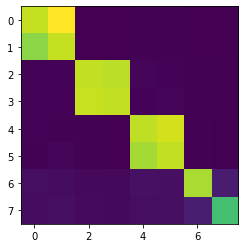

In [327]:
plt.imshow(checkmat[perm,:][:, perm])

# Analysis with Group Lasso 

In [334]:
print(encoded.shape)
print(encoded_two.shape)
print(selections)

torch.Size([30, 256, 8])
torch.Size([30, 256, 8])
[[0], [1, 6], [2, 7], [3, 5], [4]]


Selection:[1, 6]  
iter 0 : loss 5073.43310546875


/tmp/ipykernel_924/830680824.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, np.ceil(len(selections)/2), k)


iter 2500 : loss 168.98834228515625
iter 5000 : loss 163.38026428222656
iter 7500 : loss 176.47235107421875
Selection:[2, 7]  
iter 0 : loss 3992.20361328125
iter 2500 : loss 137.80712890625
iter 5000 : loss 140.3168182373047
iter 7500 : loss 144.430419921875
Selection:[3, 5]  
iter 0 : loss 7490.134765625
iter 2500 : loss 211.6783447265625
iter 5000 : loss 209.29608154296875
iter 7500 : loss 212.5189208984375


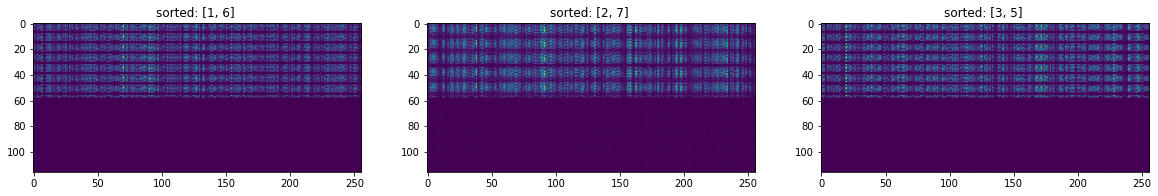

In [347]:
reload(ol)
changeUstat_lasso = []
k=0
plt.figure(figsize=(20,10))
for selection in selections:
    if len(selection)> 1: 
    #if selection == [1,6]:
        print(f"""Selection:{selection}  """)
        k = k+1
        plt.subplot(2, np.ceil(len(selections)/2), k)
        
        #prepare 
        encodedU = (encoded.to('cpu') @ ChangeB.U).detach()[:, :, selection] 
        encoded_twoU = (encoded_two.to('cpu') @ ChangeB.U).detach()[:, :, selection] 
        
        
        #train, for 16 
        #changeBR = ol.trainP(encodedU, encoded_twoU, iters=10000, lr=0.005, monitor=2500, reg=30.0)
        #changeBR = ol.trainP(encodedU, encoded_twoU, iters=12500, lr=0.0025, monitor=2500, reg=50.0)
        #changeBR = ol.trainP(encodedU, encoded_twoU, iters=8000, lr=0.005, monitor=2500, reg=2.0)
        encodedUP = changeBR(encodedU).detach()
        
        #train, for 8
        changeBR = ol.trainP(encodedU, encoded_twoU, iters=8000, lr=0.0025, monitor=2500, reg=50.0)
        encoded_twoUP = changeBR(encoded_twoU).detach()
        
        
        #Show
        deltaU = encodedUP[1:] - encodedUP[0]
        deltaU = einops.rearrange(deltaU, 't s a -> (t a) s')
        
        delta_twoU = encoded_twoUP[1:] - encoded_twoUP[0]
        delta_twoU = einops.rearrange(delta_twoU, 't s a -> (t a) s')



        #plt.figure(figsize=(10,10))

        deltaUsort, delta_twoUsort, (onewin, twowin) = ol.sort_pair_col(deltaU, delta_twoU)
        onewins.append(onewin)
        twowins.append(twowin)

        changeUstat_lasso.append({'selection': selection, 
                           'partition': (onewin, twowin), 
                           'changeb' : changeb, 
                           'deltaU': deltaU, 
                           'delta_twoU': delta_twoU})


        
        plt.imshow(torch.cat([torch.abs(deltaUsort.detach().to('cpu')),  torch.abs(delta_twoUsort.detach().to('cpu'))]  ))
        plt.title(f"""sorted: {selection} """)
        
        
        

torch.Size([29, 256, 2]) torch.Size([29, 256, 2])
tensor(2814.7698)
tensor(295.9286)


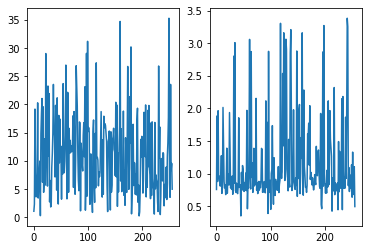

In [338]:
delta = encodedU[1:] - encodedU[0]
deltaB = changeBR(delta).detach()
print(delta.shape, deltaB.shape)

delta = rearrange(delta, 't s a -> (t a) s')
deltaB = rearrange(deltaB, 't s a -> (t a) s')
plt.subplot(1,2,1)
#plt.imshow(torch.abs(delta))
plt.plot(torch.sqrt(torch.sum(delta ** 2, axis=0)))
plt.subplot(1,2,2)
#plt.imshow(torch.abs(deltaB))
plt.plot(torch.sqrt(torch.sum(deltaB ** 2, axis=0)))


print(torch.sum(torch.sqrt(torch.sum(delta ** 2, axis=0))))
print(torch.sum(torch.sqrt(torch.sum(deltaB ** 2, axis=0))))

In [ ]:
selections

In [ ]:
torch.cat([encodedU, encoded_twoU]).shape

In [333]:
1+1

2